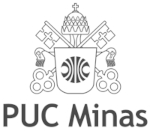

## Programa de Pós Graduação em Informática

### Disciplina: Indução de Regras e Árvores de Decisão

### Aluno: Felipe A. L. Reis

In [1]:
import datetime
import os, shutil
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, RepeatedStratifiedKFold

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#impressão de árvore de decisão
from sklearn.tree import export_graphviz
from io import StringIO
import pydotplus

In [2]:
def load_data(filename):
    data = pd.read_csv(filename, delimiter=',')
        
    # Remove duplicate
    data = data[~data.ID.duplicated(keep='first')]
    
    return data

def split_data(x_data, y_data, test_size=0.2):
    """Função para divisão dos conjuntos de treinamento e testes."""

    return train_test_split(
        x_data,
        y_data, 
        test_size = test_size, #percentual do conjunto de treino
        #random_state = 10 #seed random, para resultados semelhantes
        shuffle = True
    )

def performance_measure(confusion_matrix):
    """Função para cálculo de métricas de desempenho do algoritmo, baseado na matriz de confusão."""

    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)

    return (TPR, TNR, FPR, FNR)

def print_statistics(y_test, predictions):
    print("Precisão:  ", metrics.precision_score(y_test, predictions, average='macro'))
    print("Revocação: ", metrics.recall_score(y_test, predictions, average='macro'))
    print("F1 Score:  ", metrics.f1_score(y_test, predictions, average='macro'))
    print("Acurácia:  ", metrics.accuracy_score(y_test, predictions))
    print("Report:")
    print(metrics.classification_report(y_test, predictions))

    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    TPR, TNR, FPR, FNR = performance_measure(confusion_matrix)
    print("TPR", TPR)
    print("TNR", TNR)
    print("FPR", FPR)
    print("FNR", FNR)
    print()

    confusion_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
    confusion_display.plot()
    
def draw_tree(tree_classifier, feature_names=None, class_names=None, filename='tree.png'):
    dot_data = StringIO()
    export_graphviz(tree_classifier, out_file=dot_data,  
                    feature_names=feature_names, class_names=class_names,
                    proportion=True, rounded=True, filled=True, 
                    rotate=True, impurity=False, label='all')

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(filename)
    
def seaborn_plot(g, title=None, title_pos=1.03):
    sns.set_theme(style="whitegrid")
    g.despine(left=True)
    
    if(g.legend != None):
        g.legend.set_title("")
        
    if(g.fig != None):
        g.fig.suptitle(title, y=title_pos, fontsize = 16)

---
# Aprendizado de Dados de Saúde Pública da Coréia do Sul

O trabalho a seguir foi desenvolvido para tarefas de aprendizado de máquinas em uma base de dados de saúde pública da Coréia.

A base é denominada **[National Health Insurance Corporation_Health Checkup Information](https://www.data.go.kr/data/15007122/fileData.do#/layer_data_infomation)** (tradução automática de coreano para inglês) e está disponível no [portal público de dados do governo da Coréia](https://www.data.go.kr/data/15007122/fileData.do#/layer_data_infomation).

A base de dados foi obtida à partir da base **[Body signal of smoking](https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking)**, disponível no [Kaglle](https://www.kaggle.com/). Essa última base corresponde a uma versão simplificada da base original.

A base [National Health Insurance Corporation_Health Checkup Information](https://www.data.go.kr/data/15007122/fileData.do#/layer_data_infomation) contém 1.000.000 de registros de check-up de saúde e seus dependentes com mais de 40 anos, membros locais que são chefes de família e membros locais com mais de 40 anos e aqueles que atingiram a idade de 40 e 66 entre os sujeitos a check-up geral de saúde.

São dados abertos que consistem em informações básicas (sexo, idade, código do teste, etc.) e detalhes do exame (altura, peso, colesterol total, hemoglobina, etc.).

As informações de uso de cigarros não englobam cigarros eletrônicos.

### Dicionário de Dados

Uma vez que a base de dados está disponível apenas em coreano, foi utilizado o Google Tradutor para auxiliar na tarefa de entendimento dos rótulos de dados e códigos disponíveis.

A base de dados foi rotulada com auxílio do dicionário de dados, disponível no arquivo "National Health Information Data Health Checkup Information User Manual_20171027" (dentro do menu "Periodic historical data (20 cases"), na página da [base de dados](https://www.data.go.kr/data/15007122/fileData.do#/layer_data_infomation).

O arquivo está disponível em formato hwp (equivalente ao Word, para arquivos em coreano) e foi aberto com auxílio de um [visualizador online](https://appzend.herokuapp.com/hwpviewer/).

Abaixo estão descritas algumas informações importantes acerca dos dados disponíveis na base.

#### Código da Localidade (Try Code)

* 11 Seul
* 26 Busan
* 27 Cidade Metropolitana de Daegu
* 28 Incheon Cidade Metropolitana
* 29 Gwangju
* 30 Daejeon
* 31 Cidade Metropolitana de Ulsan
* 36 Cidade Autônoma Especial de Sejong
* 41 Gyeonggi-do
* 42 Gangwon-do
* 43 Chungcheongbuk-do
* 44 Chungcheongnam-do
* 45 Jeollabuk-do
* 46 Jeollanam-do
* 47 Gyeongsangbuk-do
* 48 Gyeongsangnam-do
* 49 Província Autônoma Especial de Jeju

#### Gênero 

* 1 = masculino
* 2 = feminino

#### Idade

*  1 = 0-4
*  2 = 5-9
*  3 = 10-14
*  4 = 15-19
*  5 = 20-24
*  6 = 25-29
*  7 = 30-34
*  8 = 35-39
*  9 = 40-44
* 10 = 45-49
* 11 = 50-54
* 12 = 55-59
* 13 = 60-64
* 14 = 65-69
* 15 = 70-74
* 16 = 75-79
* 17 = 80-84
* 18 = 85+

#### Altura e Peso

Altura e pesos são arredondados para baixo, em intervalos de 5-5cm (ex.: 100~104cm -> 100cm)

#### Visão (Olhos Esquerdos e Direitos)

É expresso como um valor entre 0,1 e 2,5. 
A acuidade visual inferior a 0,1 é indicada como 0,1 e a cegueira como 9,9.

#### Audição (Ouvidos Esquerdos e Direitos)

São usados os seguintes códigos:

* 1 = normal
* 2 = anormal

#### Colesteróis Totais

O valor normal é de 150~250mg/dL, cerca de 1/3 é colesterol do tipo HDL, e o resto é LDL.

#### Ast Sgot (Aspartate aminotransferase (AST) / Serum Glutamic-Oxaloacetic Transaminase (SGOT))

Valores de exames de sangue que indicam função hepática, exceto hepatócitos
É uma enzima que também está presente no intestino, rim, cérebro e músculo.
A concentração aumenta quando danificado.

Valor normal 0-40IU/L

#### Alt Sgpt (Alanine Aminotransferase (ALT) / Serum Glutamic Pyruvic Transaminase (SGPT))

Valores de exames de sangue que indicam função hepática, exceto hepatócitos
É uma enzima que também está presente no intestino, rim, cérebro e músculo.
A concentração aumenta quando danificado.

Valor normal 0-40IU/L

#### Gama GPT

Valores de exames de sangue indicando função hepática, trato biliar no fígado
É uma enzima presente no tubo) que converte o ácido glutâmico em peptídeos ou aminoácidos.
Atua como um transportador de ácido, excreção biliar prejudicada (bile), hepatócitos
Aumento no sangue quando ocorre um distúrbio.

Normal: Masculino 11-63IU/L, Feminino 8-35IU/L

#### Fumantes

* 1 = I don't smoke
* 2 = I smoked before, but I quit
* 3 = I still smoke




---
# Carregamento da Base e Análise Inicial dos Dados

In [3]:
data = load_data('dataset/smoking-dataset-label.csv')
data

year       ID  try_code  gender  age_code  height  weight  waist  \
0       2020        1        36       1         9     165      60   72.1   
1       2020        2        27       2        13     150      65   81.0   
2       2020        3        11       2        12     155      55   70.0   
3       2020        4        31       1        13     160      70   90.8   
4       2020        5        41       2        12     155      50   75.2   
...      ...      ...       ...     ...       ...     ...     ...    ...   
999995  2020   999996        41       2        13     145      55   81.0   
999996  2020   999997        26       2        12     160      55   76.5   
999997  2020   999998        48       1         9     175      70   85.0   
999998  2020   999999        48       2         9     160      70   91.0   
999999  2020  1000000        28       1        11     160      55   76.1   

        sight_left  sight_right  ...  serum_creatinine  ast_sgot  alt_sgpt  \
0              1.2          1.5  ...               1.1      21.0      27.0   
1              0.8          0.8  ...               0.5      18.0      15.0   
2              0.6          0.7  ...               0.7      27.0      25.0   
3              1.0          1.0  ...               1.2      65.0      97.0   
4              1.5          1.2  ...               0.7      18.0      17.0   
...            ...          ...  ...               ...       ...       ...   
999995         0.9          1.0  ...               0.6      21.0      25.0   
999996         1.5          1.5  ...               0.8      21.0      14.0   
999997         1.2          1.2  ...               0.9      26.0      20.0   
999998         0.6          0.5  ...               1.0      25.0      29.0   
999999         2.0          2.0  ...               0.9      17.0      13.0   

        gama_gtp  smoking_status  drinking  dental_examination  dental_caries  \
0           21.0             1.0       0.0                   0            NaN   
1           15.0             1.0       0.0                   0            NaN   
2            7.0             1.0       0.0                   0            NaN   
3           72.0             1.0       0.0                   1            0.0   
4           14.0             1.0       0.0                   0            NaN   
...          ...             ...       ...                 ...            ...   
999995      18.0             1.0       0.0                   0            NaN   
999996      19.0             1.0       1.0                   0            NaN   
999997      17.0             1.0       1.0                   0            NaN   
999998      13.0             1.0       0.0                   0            NaN   
999999      24.0             2.0       0.0                   0            NaN   

        dental_tartar  release_date  
0                 NaN    2021-12-29  
1                 NaN    2021-12-29  
2                 NaN    2021-12-29  
3                 0.0    2021-12-29  
4                 NaN    2021-12-29  
...               ...           ...  
999995            NaN    2021-12-29  
999996            NaN    2021-12-29  
999997            NaN    2021-12-29  
999998            NaN    2021-12-29  
999999            NaN    2021-12-29  

[1000000 rows x 31 columns]

In [4]:
data.columns

Index(['year', 'ID', 'try_code', 'gender', 'age_code', 'height', 'weight',
       'waist', 'sight_left', 'sight_right', 'hearing_left', 'hearing_right',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose',
       'total_cholesterol', 'triglycerides', 'hdl_cholesterol',
       'ldl_cholesterol', 'hemoglobin', 'urine_protein', 'serum_creatinine',
       'ast_sgot', 'alt_sgpt', 'gama_gtp', 'smoking_status', 'drinking',
       'dental_examination', 'dental_caries', 'dental_tartar', 'release_date'],
      dtype='object')

### Remoção de Atributos

Remove colunas desnecessárias.

In [5]:
data = data.drop('year', axis=1)               #somente ano 2020
#data = data.drop('ID', axis=1)                 #identificador do paciente
data = data.drop('try_code', axis=1)           #código da localidade
data = data.drop('urine_protein', axis=1)      #proteína na urina (maior parte dos valores iguais a 1)
data = data.drop('dental_tartar', axis=1)      #tártaro nos dentes
data = data.drop('release_date', axis=1)       #data de disponibilização dos dados
data

ID  gender  age_code  height  weight  waist  sight_left  \
0             1       1         9     165      60   72.1         1.2   
1             2       2        13     150      65   81.0         0.8   
2             3       2        12     155      55   70.0         0.6   
3             4       1        13     160      70   90.8         1.0   
4             5       2        12     155      50   75.2         1.5   
...         ...     ...       ...     ...     ...    ...         ...   
999995   999996       2        13     145      55   81.0         0.9   
999996   999997       2        12     160      55   76.5         1.5   
999997   999998       1         9     175      70   85.0         1.2   
999998   999999       2         9     160      70   91.0         0.6   
999999  1000000       1        11     160      55   76.1         2.0   

        sight_right  hearing_left  hearing_right  ...  ldl_cholesterol  \
0               1.5           1.0            1.0  ...            118.0   
1               0.8           1.0            1.0  ...              NaN   
2               0.7           1.0            1.0  ...              NaN   
3               1.0           1.0            2.0  ...              NaN   
4               1.2           1.0            1.0  ...            133.0   
...             ...           ...            ...  ...              ...   
999995          1.0           1.0            1.0  ...             75.0   
999996          1.5           1.0            1.0  ...            198.0   
999997          1.2           1.0            1.0  ...              NaN   
999998          0.5           1.0            1.0  ...            126.0   
999999          2.0           1.0            1.0  ...            156.0   

        hemoglobin  serum_creatinine  ast_sgot  alt_sgpt  gama_gtp  \
0             15.0               1.1      21.0      27.0      21.0   
1             12.7               0.5      18.0      15.0      15.0   
2             12.8               0.7      27.0      25.0       7.0   
3             16.4               1.2      65.0      97.0      72.0   
4             12.4               0.7      18.0      17.0      14.0   
...            ...               ...       ...       ...       ...   
999995        13.6               0.6      21.0      25.0      18.0   
999996        14.0               0.8      21.0      14.0      19.0   
999997        16.0               0.9      26.0      20.0      17.0   
999998        11.9               1.0      25.0      29.0      13.0   
999999        14.9               0.9      17.0      13.0      24.0   

        smoking_status  drinking  dental_examination  dental_caries  
0                  1.0       0.0                   0            NaN  
1                  1.0       0.0                   0            NaN  
2                  1.0       0.0                   0            NaN  
3                  1.0       0.0                   1            0.0  
4                  1.0       0.0                   0            NaN  
...                ...       ...                 ...            ...  
999995             1.0       0.0                   0            NaN  
999996             1.0       1.0                   0            NaN  
999997             1.0       1.0                   0            NaN  
999998             1.0       0.0                   0            NaN  
999999             2.0       0.0                   0            NaN  

[1000000 rows x 26 columns]

### Conversão de Código de Gênero

Criação de código numérico de gênero em M/F, para facilitar a filtragem de dados.

In [6]:
data['gender_num'] = data['gender']
data['gender'] = data['gender'].transform(lambda x: 'M' if x == 1 else 'F').astype('string')
data[['gender']]

gender
0           M
1           F
2           F
3           M
4           F
...       ...
999995      F
999996      F
999997      M
999998      F
999999      M

[1000000 rows x 1 columns]

### Conversão de Código em Faixa de Idade

Conversão do código de idade em idade, em faixas de 5 anos.

In [7]:
data['age'] = ((data['age_code']-1) * 5)
data[['age_code', 'age']]

age_code  age
0              9   40
1             13   60
2             12   55
3             13   60
4             12   55
...          ...  ...
999995        13   60
999996        12   55
999997         9   40
999998         9   40
999999        11   50

[1000000 rows x 2 columns]

### Conversão de Dados de Consumo de Álcool

Conversão de códigos numéricos relacionados ao consumo de álcool.

In [8]:
pd.unique(data.drinking)

array([ 0.,  1., nan])

In [9]:
data['drink'] = data['drinking'].transform(
    lambda x: 'S' if x == 1.0 else('N' if x == 0.0 else None)).astype('string')
data[['drinking', 'drink']]

drinking drink
0            0.0     N
1            0.0     N
2            0.0     N
3            0.0     N
4            0.0     N
...          ...   ...
999995       0.0     N
999996       1.0     S
999997       1.0     S
999998       0.0     N
999999       0.0     N

[1000000 rows x 2 columns]

### Conversão de Dados de Consumo de Tabaco

Conversão de códigos numéricos relacionados uso de tabaco.

In [10]:
pd.unique(data.smoking_status)

array([ 1.,  3.,  2., nan])

In [11]:
data['smoking'] = data['smoking_status'].transform(
    lambda x: 'NF' if x == 1.0 else('EX' if x == 2.0 else ('FU' if x == 3.0 else ""))
).astype('string')
data[['smoking', 'smoking_status']]

smoking  smoking_status
0           NF             1.0
1           NF             1.0
2           NF             1.0
3           NF             1.0
4           NF             1.0
...        ...             ...
999995      NF             1.0
999996      NF             1.0
999997      NF             1.0
999998      NF             1.0
999999      EX             2.0

[1000000 rows x 2 columns]

### Conversão de Dados relacionados à Saúde Bucal

Caso seja necessário, um paciente pode ser indicado a um exame bucal (ir ao dentista).
Esse procedimento não é obrigatório para todas as pessoas, sendo indicado pelo médico.
Todos os pacientes que foram submetidos ao dentista possuem informação sobre existência ou não de cáries. 
Os demais pacientes não possuem essa informação cadastrada.

No dentista, o paciente pode receber informações sobre a existência de cáries e/ou tártaros.
Somente serão considerados casos de cáries. 

In [12]:
#pd.unique(data['dental_caries'])
pd.unique(data['dental_examination'])

array([0, 1])

In [13]:
data['dentist'] = data['dental_examination'].transform(
    lambda x: 'S' if x == 1.0 else ('N' if x == 0.0 else None)
).astype('string')

data['caries'] = data['dental_caries'].transform(
    lambda x: 'S' if x == 1.0 else('N' if x == 0.0 else None)
).astype('string')

data[['dental_examination', 'dentist', 'dental_caries', 'caries']]

dental_examination dentist  dental_caries caries
0                        0       N            NaN   <NA>
1                        0       N            NaN   <NA>
2                        0       N            NaN   <NA>
3                        1       S            0.0      N
4                        0       N            NaN   <NA>
...                    ...     ...            ...    ...
999995                   0       N            NaN   <NA>
999996                   0       N            NaN   <NA>
999997                   0       N            NaN   <NA>
999998                   0       N            NaN   <NA>
999999                   0       N            NaN   <NA>

[1000000 rows x 4 columns]

### Atributo IMC

Criação de atributo de massa corporal, com base na altura e no peso.

In [14]:
data['imc'] = (data['weight'] / ((data['height']/100)**2))
data[['weight', 'height', 'imc']]

weight  height        imc
0           60     165  22.038567
1           65     150  28.888889
2           55     155  22.892820
3           70     160  27.343750
4           50     155  20.811655
...        ...     ...        ...
999995      55     145  26.159334
999996      55     160  21.484375
999997      70     175  22.857143
999998      70     160  27.343750
999999      55     160  21.484375

[1000000 rows x 3 columns]

### Atributo Grau de IMC (Classificação)

Criação de atributo correspondente à classificação do IMC, em graus, conforme modelo:

| Classificação    | IMC          |
|------------------|--------------|
| Baixo Peso       | <= 18.5      |
| Normal           | 18.5 - 24.9  |
| Sobrepeso        | 24.9 - 29.9  |
| Obesidade Grau 1 | 29.9 - 34.9  |
| Obesidade Grau 2 | 34.9 - 39.9  |
| Obesidade Grau 3 | > 39.9       |

In [15]:
#fonte: https://www.brainlatam.com/blog/neuromodulacao-pode-ajudar-contra-obesidade-1281

data['imc_grau'] = data['imc'].transform(lambda imc: 
    "BP" if imc <= 18.5 
    else ( "N" if (imc > 18.5 and imc <= 24.9) 
    else ("SP" if (imc > 24.9 and imc <= 29.9) 
    else ("O1" if (imc > 29.9 and imc <= 34.9) 
    else ("O2" if (imc > 34.9 and imc <= 39.9) 
    else ("O3")))))
).astype('string')

data[['weight', 'height', 'imc', 'imc_grau']]

weight  height        imc imc_grau
0           60     165  22.038567        N
1           65     150  28.888889       SP
2           55     155  22.892820        N
3           70     160  27.343750       SP
4           50     155  20.811655        N
...        ...     ...        ...      ...
999995      55     145  26.159334       SP
999996      55     160  21.484375        N
999997      70     175  22.857143        N
999998      70     160  27.343750       SP
999999      55     160  21.484375        N

[1000000 rows x 4 columns]

### Remoção de Outros Atributos

In [16]:
data = data.drop('age_code', axis=1)
data = data.drop('hearing_left', axis=1)
data = data.drop('hearing_right', axis=1)
data = data.drop('sight_left', axis=1)
data = data.drop('sight_right', axis=1)
data = data.drop('dental_examination', axis=1)
data = data.drop('dental_caries', axis=1)
data

ID gender  height  weight  waist  systolic_blood_pressure  \
0             1      M     165      60   72.1                    127.0   
1             2      F     150      65   81.0                    110.0   
2             3      F     155      55   70.0                    123.0   
3             4      M     160      70   90.8                    134.0   
4             5      F     155      50   75.2                    144.0   
...         ...    ...     ...     ...    ...                      ...   
999995   999996      F     145      55   81.0                    132.0   
999996   999997      F     160      55   76.5                    100.0   
999997   999998      M     175      70   85.0                    110.0   
999998   999999      F     160      70   91.0                    137.0   
999999  1000000      M     160      55   76.1                    133.0   

        diastolic_blood_pressure  glucose  total_cholesterol  triglycerides  \
0                           79.0     90.0              188.0           58.0   
1                           73.0     87.0                NaN            NaN   
2                           80.0    102.0                NaN            NaN   
3                           84.0    146.0                NaN            NaN   
4                           89.0    110.0              220.0          171.0   
...                          ...      ...                ...            ...   
999995                      78.0    124.0              178.0          301.0   
999996                      64.0     98.0              288.0           93.0   
999997                      64.0     83.0                NaN            NaN   
999998                      82.0    111.0              208.0          113.0   
999999                      74.0    121.0              237.0           63.0   

        ...  smoking_status  drinking  gender_num  age  drink  smoking  \
0       ...             1.0       0.0           1   40      N       NF   
1       ...             1.0       0.0           2   60      N       NF   
2       ...             1.0       0.0           2   55      N       NF   
3       ...             1.0       0.0           1   60      N       NF   
4       ...             1.0       0.0           2   55      N       NF   
...     ...             ...       ...         ...  ...    ...      ...   
999995  ...             1.0       0.0           2   60      N       NF   
999996  ...             1.0       1.0           2   55      S       NF   
999997  ...             1.0       1.0           1   40      S       NF   
999998  ...             1.0       0.0           2   40      N       NF   
999999  ...             2.0       0.0           1   50      N       EX   

        dentist  caries        imc  imc_grau  
0             N    <NA>  22.038567         N  
1             N    <NA>  28.888889        SP  
2             N    <NA>  22.892820         N  
3             S       N  27.343750        SP  
4             N    <NA>  20.811655         N  
...         ...     ...        ...       ...  
999995        N    <NA>  26.159334        SP  
999996        N    <NA>  21.484375         N  
999997        N    <NA>  22.857143         N  
999998        N    <NA>  27.343750        SP  
999999        N    <NA>  21.484375         N  

[1000000 rows x 27 columns]

In [17]:
#data.to_csv('dataset/smoking-dataset-initial.csv')

---
---
# Análise Exploratória

Disponível no arquivo [smoking-analysis.ipynb](smoking-analysis.ipynb).

---
---
# Pré Processamento

Esta seção será utilizada para pré processamento da base de dados, realizando as seguinte etapas:

1. Remoção de *outliers*
2. Balanceamento dos dados
3. Processamento de dados ausentes 
4. Processamento de dados inconsistentes
5. Conversão de dados
6. Redução de dimensionalidade 
7. Transformação de atributos

In [18]:
data = load_data('dataset/smoking-dataset-initial.csv')
data

Unnamed: 0       ID gender  height  weight  waist  \
0                0        1      M     165      60   72.1   
1                1        2      F     150      65   81.0   
2                2        3      F     155      55   70.0   
3                3        4      M     160      70   90.8   
4                4        5      F     155      50   75.2   
...            ...      ...    ...     ...     ...    ...   
999995      999995   999996      F     145      55   81.0   
999996      999996   999997      F     160      55   76.5   
999997      999997   999998      M     175      70   85.0   
999998      999998   999999      F     160      70   91.0   
999999      999999  1000000      M     160      55   76.1   

        systolic_blood_pressure  diastolic_blood_pressure  glucose  \
0                         127.0                      79.0     90.0   
1                         110.0                      73.0     87.0   
2                         123.0                      80.0    102.0   
3                         134.0                      84.0    146.0   
4                         144.0                      89.0    110.0   
...                         ...                       ...      ...   
999995                    132.0                      78.0    124.0   
999996                    100.0                      64.0     98.0   
999997                    110.0                      64.0     83.0   
999998                    137.0                      82.0    111.0   
999999                    133.0                      74.0    121.0   

        total_cholesterol  ...  smoking_status  drinking  gender_num  age  \
0                   188.0  ...             1.0       0.0           1   40   
1                     NaN  ...             1.0       0.0           2   60   
2                     NaN  ...             1.0       0.0           2   55   
3                     NaN  ...             1.0       0.0           1   60   
4                   220.0  ...             1.0       0.0           2   55   
...                   ...  ...             ...       ...         ...  ...   
999995              178.0  ...             1.0       0.0           2   60   
999996              288.0  ...             1.0       1.0           2   55   
999997                NaN  ...             1.0       1.0           1   40   
999998              208.0  ...             1.0       0.0           2   40   
999999              237.0  ...             2.0       0.0           1   50   

        drink  smoking  dentist  caries        imc  imc_grau  
0           N       NF        N     NaN  22.038567         N  
1           N       NF        N     NaN  28.888889        SP  
2           N       NF        N     NaN  22.892820         N  
3           N       NF        S       N  27.343750        SP  
4           N       NF        N     NaN  20.811655         N  
...       ...      ...      ...     ...        ...       ...  
999995      N       NF        N     NaN  26.159334        SP  
999996      S       NF        N     NaN  21.484375         N  
999997      S       NF        N     NaN  22.857143         N  
999998      N       NF        N     NaN  27.343750        SP  
999999      N       EX        N     NaN  21.484375         N  

[1000000 rows x 28 columns]

### --------------------------------------------------
### Amostra Dados (TODO:Remover)

In [19]:
#reduz a quantidade de dados, para diminuir o tempo de processamento, durante os testes
#data = data[(data.smoking != 'EX')]
data = data.sample(frac=0.1)
print(len(data))

100000


### --------------------------------------------------

#### Remoção de Dados de Consumo de Tabaco sem Classificação

In [20]:
data = data[(data.smoking != "")] #343 registros
data

Unnamed: 0      ID gender  height  weight  waist  \
115185      115185  115186      M     165      65   80.0   
542393      542393  542394      F     150      50   78.1   
995372      995372  995373      M     165      65   78.0   
835299      835299  835300      M     170      70   91.0   
958829      958829  958830      M     160      70   86.0   
...            ...     ...    ...     ...     ...    ...   
308230      308230  308231      M     180      95   96.0   
918012      918012  918013      F     145      65   96.8   
513508      513508  513509      F     165      50   60.0   
581529      581529  581530      F     155      50   72.0   
754143      754143  754144      M     170      75   82.0   

        systolic_blood_pressure  diastolic_blood_pressure  glucose  \
115185                    127.0                      80.0     99.0   
542393                    104.0                      66.0     83.0   
995372                    110.0                      70.0     79.0   
835299                    155.0                     102.0    106.0   
958829                    117.0                      74.0    165.0   
...                         ...                       ...      ...   
308230                    124.0                      76.0     86.0   
918012                    114.0                      75.0    161.0   
513508                    110.0                      65.0     84.0   
581529                     90.0                      62.0     78.0   
754143                    122.0                      79.0     93.0   

        total_cholesterol  ...  smoking_status  drinking  gender_num  age  \
115185                NaN  ...             3.0       1.0           1   50   
542393              172.0  ...             1.0       1.0           2   60   
995372                NaN  ...             1.0       0.0           1   45   
835299                NaN  ...             2.0       1.0           1   50   
958829              224.0  ...             2.0       1.0           1   55   
...                   ...  ...             ...       ...         ...  ...   
308230                NaN  ...             2.0       1.0           1   50   
918012                NaN  ...             1.0       0.0           2   55   
513508                NaN  ...             1.0       1.0           2   40   
581529              219.0  ...             1.0       0.0           2   40   
754143                NaN  ...             2.0       1.0           1   50   

        drink  smoking  dentist  caries        imc  imc_grau  
115185      S       FU        N     NaN  23.875115         N  
542393      S       NF        S       N  22.222222         N  
995372      N       NF        N     NaN  23.875115         N  
835299      S       EX        N     NaN  24.221453         N  
958829      S       EX        S       N  27.343750        SP  
...       ...      ...      ...     ...        ...       ...  
308230      S       EX        S       N  29.320988        SP  
918012      N       NF        N     NaN  30.915577        O1  
513508      S       NF        N     NaN  18.365473        BP  
581529      N       NF        S       N  20.811655         N  
754143      S       EX        S       N  25.951557        SP  

[100000 rows x 28 columns]

### 1. Processamento de dados inconsistentes

In [21]:
#não realizado

### 2. Processamento de dados ausentes 

In [22]:
class_names = ['imc','gender_num','waist','age',
               'systolic_blood_pressure',
               'diastolic_blood_pressure','glucose',
               'total_cholesterol','triglycerides',
               'hdl_cholesterol','ldl_cholesterol',
               'hemoglobin','serum_creatinine',
               'ast_sgot','alt_sgpt','gama_gtp',
               'drinking','smoking_status']
#               'gender','smoking','smoking_status']

data = data[class_names]
data

imc  gender_num  waist  age  systolic_blood_pressure  \
115185  23.875115           1   80.0   50                    127.0   
542393  22.222222           2   78.1   60                    104.0   
995372  23.875115           1   78.0   45                    110.0   
835299  24.221453           1   91.0   50                    155.0   
958829  27.343750           1   86.0   55                    117.0   
...           ...         ...    ...  ...                      ...   
308230  29.320988           1   96.0   50                    124.0   
918012  30.915577           2   96.8   55                    114.0   
513508  18.365473           2   60.0   40                    110.0   
581529  20.811655           2   72.0   40                     90.0   
754143  25.951557           1   82.0   50                    122.0   

        diastolic_blood_pressure  glucose  total_cholesterol  triglycerides  \
115185                      80.0     99.0                NaN            NaN   
542393                      66.0     83.0              172.0           69.0   
995372                      70.0     79.0                NaN            NaN   
835299                     102.0    106.0                NaN            NaN   
958829                      74.0    165.0              224.0          148.0   
...                          ...      ...                ...            ...   
308230                      76.0     86.0                NaN            NaN   
918012                      75.0    161.0                NaN            NaN   
513508                      65.0     84.0                NaN            NaN   
581529                      62.0     78.0              219.0           46.0   
754143                      79.0     93.0                NaN            NaN   

        hdl_cholesterol  ldl_cholesterol  hemoglobin  serum_creatinine  \
115185              NaN              NaN        15.2               1.0   
542393             51.0            107.0        13.6               0.8   
995372              NaN              NaN        14.8               0.7   
835299              NaN              NaN        15.0               0.9   
958829             48.0            159.0        14.6               1.1   
...                 ...              ...         ...               ...   
308230              NaN              NaN        14.1               0.8   
918012              NaN              NaN        13.3               0.8   
513508              NaN              NaN        12.5               0.7   
581529             65.0            145.0        13.0               0.7   
754143              NaN              NaN        15.3               0.9   

        ast_sgot  alt_sgpt  gama_gtp  drinking  smoking_status  
115185      34.0      32.0      31.0       1.0             3.0  
542393      19.0      13.0      17.0       1.0             1.0  
995372      36.0      34.0      16.0       0.0             1.0  
835299      31.0      24.0     112.0       1.0             2.0  
958829      15.0      16.0      90.0       1.0             2.0  
...          ...       ...       ...       ...             ...  
308230      20.0      22.0      43.0       1.0             2.0  
918012      20.0      24.0      29.0       0.0             1.0  
513508      18.0      18.0      41.0       1.0             1.0  
581529      23.0      20.0      14.0       0.0             1.0  
754143      20.0      16.0      10.0       1.0             2.0  

[100000 rows x 18 columns]

In [23]:
#https://scikit-learn.org/stable/modules/impute.html
#https://mkang32.github.io/python/2020/11/21/Missing-data-imputation-using-sklearn.html

#### Simple Imputer

Imputação de dados ausentes pela média.

In [24]:
'''
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)
imp_fit = imputer.fit(data.sample(frac=0.1))
idata = pd.DataFrame(imp_fit.transform(data))

idata.columns = data.columns
idata.index = data.index
idata
'''

"\nimputer = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)\nimp_fit = imputer.fit(data.sample(frac=0.1))\nidata = pd.DataFrame(imp_fit.transform(data))\n\nidata.columns = data.columns\nidata.index = data.index\nidata\n"

#### Iterative Imputer

Imputação de dados ausentes utilizando técnica multivariada.
Nela, os dados imputados são dependentes das demais features.

In [25]:
#provavelmente o KNN Imputer terá um melhor resultado, porém é muito lenta sua execução.
min_date = datetime.datetime.now()

#imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputer = IterativeImputer(random_state=0)
idata = pd.DataFrame(imputer.fit_transform(data))
idata.columns = data.columns
idata.index = data.index
#idata

max_date = datetime.datetime.now()
print(max_date-min_date)

0:00:09.820178


/home/falreis/anaconda3/envs/arvores/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### 3. Remoção Outliers

In [26]:
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
# https://www.researchgate.net/post/Which-is-the-best-method-for-removing-outliers-in-a-data-set

In [27]:
idata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 115185 to 754143
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   imc                       100000 non-null  float64
 1   gender_num                100000 non-null  float64
 2   waist                     100000 non-null  float64
 3   age                       100000 non-null  float64
 4   systolic_blood_pressure   100000 non-null  float64
 5   diastolic_blood_pressure  100000 non-null  float64
 6   glucose                   100000 non-null  float64
 7   total_cholesterol         100000 non-null  float64
 8   triglycerides             100000 non-null  float64
 9   hdl_cholesterol           100000 non-null  float64
 10  ldl_cholesterol           100000 non-null  float64
 11  hemoglobin                100000 non-null  float64
 12  serum_creatinine          100000 non-null  float64
 13  ast_sgot                  100000 non-nu

#### Visualização de Dados

Text(0.5, 1.0, 'Boxplot Peso')

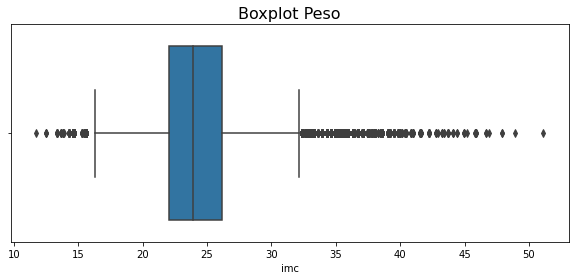

In [28]:
plt.figure(figsize = (10,4))
ax = sns.boxplot(x=idata["imc"])
plt.title("Boxplot Peso",fontsize=16)

Text(0.5, 1.0, 'Boxplot Circunferência Abdominal')

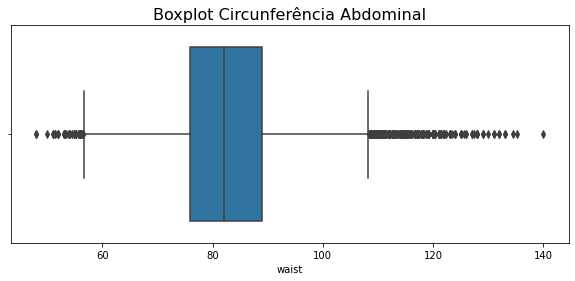

In [29]:
plt.figure(figsize = (10,4))
ax = sns.boxplot(x=idata["waist"])
plt.title("Boxplot Circunferência Abdominal",fontsize=16)

Text(0.5, 1.0, 'Boxplot Pressão Vascular Sistólica')

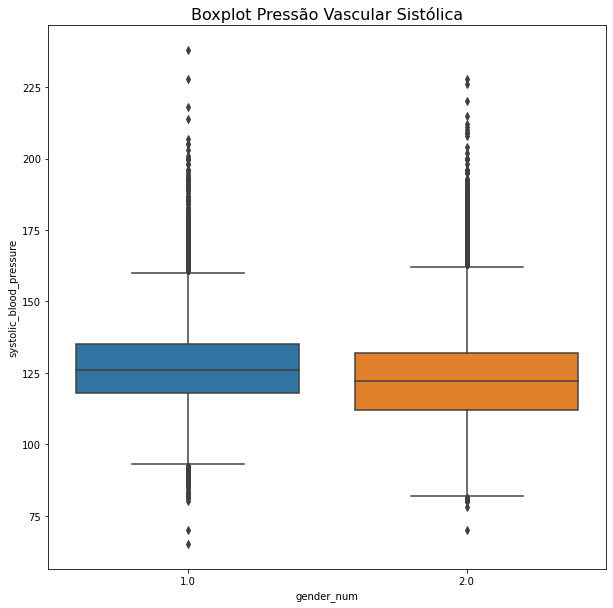

In [30]:
plt.figure(figsize = (10,10))
ax = sns.boxplot(data=idata, y="systolic_blood_pressure", x="gender_num")
plt.title("Boxplot Pressão Vascular Sistólica",fontsize=16)

#### Técnica Utilizada

Utilizar o início do código abaixo para remoção de outliers, com média +/-2*SD (desvio padrão)

* The classical approach to screen outliers is to use the standard deviation SD: For normally distributed data, all values should fall into the range of mean +/- 2SD. Observations that are outside 2SD may be considered outliers, and some may even use 3SD to rule out outliers.
* However, I have been reading about some articles that critique the use of the SD method because mean and SD are greatly influenced by the outlier and thus are unreliable.
* Some articles suggest the use of MAD （median absolute deviation）, which is similar to SD, instead of mean and SD, it uses median and MADe. So it assumes all values should fall into the range of median +/- 2MADe. MADe=1.483*MAD, MAD=median (|xi – median(x)| i=1,2,…,n) . If the values are greater than 2MADe, it is considered as outliers.
* Here is one reference, A note on detecting statistical outliers in psychophysical data by Pete R Jones. You should be able to find more.

In [31]:
describe = idata.describe()
describe

imc     gender_num          waist            age  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       24.226361       1.491790      82.336042      54.564450   
std         3.551240       0.499935       9.562391      10.846853   
min        11.718750       1.000000      48.000000      40.000000   
25%        22.038567       1.000000      76.000000      45.000000   
50%        23.875115       1.000000      82.000000      55.000000   
75%        26.159334       2.000000      88.900000      60.000000   
max        51.111111       2.000000     140.000000      85.000000   

       systolic_blood_pressure  diastolic_blood_pressure        glucose  \
count            100000.000000             100000.000000  100000.000000   
mean                124.887024                 76.790302     104.190424   
std                  14.658900                  9.906765      24.991931   
min                  65.000000                 31.000000      24.000000   
25%                 115.000000                 70.000000      91.000000   
50%                 124.000000                 77.000000      99.000000   
75%                 134.000000                 83.000000     109.000000   
max                 238.000000                178.000000     673.000000   

       total_cholesterol  triglycerides  hdl_cholesterol  ldl_cholesterol  \
count      100000.000000  100000.000000    100000.000000    100000.000000   
mean          198.342815     133.585413        56.597214       115.154885   
std            29.248126      65.709042        11.334104        26.966999   
min            63.000000     -33.809492        -1.559146      -206.583446   
25%           192.601548      99.948096        50.260486       112.566152   
50%           198.118964     124.654686        55.843763       115.352784   
75%           203.498378     153.121751        62.266939       117.334405   
max          2416.000000    2378.000000       800.000000      2395.000000   

          hemoglobin  serum_creatinine      ast_sgot       alt_sgpt  \
count  100000.000000     100000.000000  100000.00000  100000.000000   
mean       14.200300          0.853224      27.63465      26.665677   
std         1.548193          0.466953      18.33373      22.361664   
min         4.400000          0.060000       2.00000       1.000000   
25%        13.200000          0.700000      20.00000      16.000000   
50%        14.200000          0.800000      24.00000      21.000000   
75%        15.300000          1.000000      30.00000      31.000000   
max        21.900000         95.000000    1561.00000    1715.000000   

            gama_gtp       drinking  smoking_status  
count  100000.000000  100000.000000   100000.000000  
mean       37.773415       0.582781        1.554359  
std        51.764345       0.493064        0.782545  
min         1.000000       0.000000        0.868623  
25%        16.000000       0.000000        1.000000  
50%        24.000000       1.000000        1.000000  
75%        40.000000       1.000000        2.000000  
max       999.000000       1.075288        3.000000

In [32]:
for col in ['gender_num', 'drinking', 'age']:
    idata[col] = idata[col].astype('int')

idata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 115185 to 754143
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   imc                       100000 non-null  float64
 1   gender_num                100000 non-null  int64  
 2   waist                     100000 non-null  float64
 3   age                       100000 non-null  int64  
 4   systolic_blood_pressure   100000 non-null  float64
 5   diastolic_blood_pressure  100000 non-null  float64
 6   glucose                   100000 non-null  float64
 7   total_cholesterol         100000 non-null  float64
 8   triglycerides             100000 non-null  float64
 9   hdl_cholesterol           100000 non-null  float64
 10  ldl_cholesterol           100000 non-null  float64
 11  hemoglobin                100000 non-null  float64
 12  serum_creatinine          100000 non-null  float64
 13  ast_sgot                  100000 non-nu

#### Remove Outilers (2 $\times$ Desvio Padrão)

Remove outliers cujo valor seja superior a 2 $\times$ desvio-padrão.

In [33]:
'''
for col in idata.columns:
    if (idata[col].dtypes == "float64"):
        max_val = describe[col]["mean"] + (2 * describe[col]["std"])
        min_val = describe[col]["mean"] - (2 * describe[col]["std"])
        
        query = '{} >= {} and {} <= {}'.format(col, min_val, col, max_val)
        idata = idata.query(query)
'''

'\nfor col in idata.columns:\n    if (idata[col].dtypes == "float64"):\n        max_val = describe[col]["mean"] + (2 * describe[col]["std"])\n        min_val = describe[col]["mean"] - (2 * describe[col]["std"])\n        \n        query = \'{} >= {} and {} <= {}\'.format(col, min_val, col, max_val)\n        idata = idata.query(query)\n'

#### Remove Outilers usando IRQ

Remove outliers usando a técnica IRQ (Interquartile Range)

In [34]:
'''
for col in idata.columns:
    if (idata[col].dtypes == "float64"):
        q1 = describe[col]['25%']
        q3 = describe[col]['75%']
        irq = q3-q1
        
        query = '{} >= {} and {} <= {}'.format(col, (q1 - (1.5*irq)), col, (q1 + (1.5*irq)))
        idata = idata.query(query)
'''

'\nfor col in idata.columns:\n    if (idata[col].dtypes == "float64"):\n        q1 = describe[col][\'25%\']\n        q3 = describe[col][\'75%\']\n        irq = q3-q1\n        \n        query = \'{} >= {} and {} <= {}\'.format(col, (q1 - (1.5*irq)), col, (q1 + (1.5*irq)))\n        idata = idata.query(query)\n'

#### Remove Outilers usando MAD

In [35]:
'''
for col in idata.columns:
    if (idata[col].dtypes == "float64"):
        mad = data[col].mad()
        median = data[col].median()
        idata = idata.loc[ abs(idata[col] - median) / mad <= (2*mad) ]
'''

'\nfor col in idata.columns:\n    if (idata[col].dtypes == "float64"):\n        mad = data[col].mad()\n        median = data[col].median()\n        idata = idata.loc[ abs(idata[col] - median) / mad <= (2*mad) ]\n'

#### Remove 1% Superior e Inferior

Remove valores que estejam fora dos quantis 1% e 99%.

In [36]:
def cap_data(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            query = '{} >= {} and {} <= {}'.format(col, percentiles[0], col, percentiles[1])
            df = df.query(query)
    return df

idata = cap_data(idata)

In [37]:
idata

imc  gender_num  waist  age  systolic_blood_pressure  \
115185  23.875115           1   80.0   50                    127.0   
542393  22.222222           2   78.1   60                    104.0   
995372  23.875115           1   78.0   45                    110.0   
958829  27.343750           1   86.0   55                    117.0   
704085  20.000000           1   76.0   75                    144.0   
...           ...         ...    ...  ...                      ...   
349737  23.437500           2   74.2   60                    117.0   
367653  22.222222           2   73.0   60                    132.0   
308230  29.320988           1   96.0   50                    124.0   
918012  30.915577           2   96.8   55                    114.0   
754143  25.951557           1   82.0   50                    122.0   

        diastolic_blood_pressure  glucose  total_cholesterol  triglycerides  \
115185                      80.0     99.0         198.193500     144.963309   
542393                      66.0     83.0         172.000000      69.000000   
995372                      70.0     79.0         190.958582     105.059015   
958829                      74.0    165.0         224.000000     148.000000   
704085                      84.0     89.0         188.898713     101.533149   
...                          ...      ...                ...            ...   
349737                      81.0     87.0         198.366277     100.750040   
367653                      85.0     87.0         202.782500     101.354377   
308230                      76.0     86.0         194.223672     151.445094   
918012                      75.0    161.0         197.419305     168.914959   
754143                      79.0     93.0         195.953451     129.156586   

        hdl_cholesterol  ldl_cholesterol  hemoglobin  serum_creatinine  \
115185        54.516733       114.898404        15.2               1.0   
542393        51.000000       107.000000        13.6               0.8   
995372        54.168563       115.988957        14.8               0.7   
958829        48.000000       159.000000        14.6               1.1   
704085        56.381961       112.277195        12.8               1.1   
...                 ...              ...         ...               ...   
349737        61.391467       116.873527        13.6               0.7   
367653        66.138132       116.385142        13.5               0.7   
308230        49.385614       114.760848        14.1               0.8   
918012        49.301879       114.367287        13.3               0.8   
754143        54.317677       116.011845        15.3               0.9   

        ast_sgot  alt_sgpt  gama_gtp  drinking  smoking_status  
115185      34.0      32.0      31.0         1             3.0  
542393      19.0      13.0      17.0         1             1.0  
995372      36.0      34.0      16.0         0             1.0  
958829      15.0      16.0      90.0         1             2.0  
704085      22.0      14.0      32.0         0             1.0  
...          ...       ...       ...       ...             ...  
349737      25.0      17.0      10.0         0             1.0  
367653      27.0      17.0      18.0         1             1.0  
308230      20.0      22.0      43.0         1             2.0  
918012      20.0      24.0      29.0         0             1.0  
754143      20.0      16.0      10.0         1             2.0  

[77307 rows x 18 columns]

### 4. Separação de Dados e Rótulos

#### Separação de Dados e Labels

In [38]:
#definição de rótulo de dados
data_y = idata[['smoking_status']].astype('int')
data_y

smoking_status
115185               3
542393               1
995372               1
958829               2
704085               1
...                ...
349737               1
367653               1
308230               2
918012               1
754143               2

[77307 rows x 1 columns]

In [39]:
data_x = idata.drop('smoking_status', axis=1)
data_x

imc  gender_num  waist  age  systolic_blood_pressure  \
115185  23.875115           1   80.0   50                    127.0   
542393  22.222222           2   78.1   60                    104.0   
995372  23.875115           1   78.0   45                    110.0   
958829  27.343750           1   86.0   55                    117.0   
704085  20.000000           1   76.0   75                    144.0   
...           ...         ...    ...  ...                      ...   
349737  23.437500           2   74.2   60                    117.0   
367653  22.222222           2   73.0   60                    132.0   
308230  29.320988           1   96.0   50                    124.0   
918012  30.915577           2   96.8   55                    114.0   
754143  25.951557           1   82.0   50                    122.0   

        diastolic_blood_pressure  glucose  total_cholesterol  triglycerides  \
115185                      80.0     99.0         198.193500     144.963309   
542393                      66.0     83.0         172.000000      69.000000   
995372                      70.0     79.0         190.958582     105.059015   
958829                      74.0    165.0         224.000000     148.000000   
704085                      84.0     89.0         188.898713     101.533149   
...                          ...      ...                ...            ...   
349737                      81.0     87.0         198.366277     100.750040   
367653                      85.0     87.0         202.782500     101.354377   
308230                      76.0     86.0         194.223672     151.445094   
918012                      75.0    161.0         197.419305     168.914959   
754143                      79.0     93.0         195.953451     129.156586   

        hdl_cholesterol  ldl_cholesterol  hemoglobin  serum_creatinine  \
115185        54.516733       114.898404        15.2               1.0   
542393        51.000000       107.000000        13.6               0.8   
995372        54.168563       115.988957        14.8               0.7   
958829        48.000000       159.000000        14.6               1.1   
704085        56.381961       112.277195        12.8               1.1   
...                 ...              ...         ...               ...   
349737        61.391467       116.873527        13.6               0.7   
367653        66.138132       116.385142        13.5               0.7   
308230        49.385614       114.760848        14.1               0.8   
918012        49.301879       114.367287        13.3               0.8   
754143        54.317677       116.011845        15.3               0.9   

        ast_sgot  alt_sgpt  gama_gtp  drinking  
115185      34.0      32.0      31.0         1  
542393      19.0      13.0      17.0         1  
995372      36.0      34.0      16.0         0  
958829      15.0      16.0      90.0         1  
704085      22.0      14.0      32.0         0  
...          ...       ...       ...       ...  
349737      25.0      17.0      10.0         0  
367653      27.0      17.0      18.0         1  
308230      20.0      22.0      43.0         1  
918012      20.0      24.0      29.0         0  
754143      20.0      16.0      10.0         1  

[77307 rows x 17 columns]

### 5. Conversão de dados

Realizado previamente, na análise inicial das informações, conforme pode ser observado previamente (no começo do Notebook).

### 5. Separação Conjuntos de Treino e Testes

In [40]:
x_train, x_test, y_train, y_test = split_data(data_x, data_y)
print('Treino:', x_train.shape, y_train.shape)
print('Teste: ', x_test.shape, y_test.shape)

data_x, data_y = x_train, y_train

Treino: (61845, 17) (61845, 1)
Teste:  (15462, 17) (15462, 1)


### 6. Balanceamento dos dados

Conforme pode ser visto no gráfico abaixo, os dados de fumantes e não fumantes estão consideravelmente desbalanceados.

Para que o algoritmo possa aprender sem um viés, é recomendado o balanceamento dos dados.

O balanceamento dos dados será feito utilizando uma estratégia under/over, para diminuição dos dados de não fumantes e aumento dos dados de fumantes/ex-fumantes.

In [41]:
# https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

#### Oversampling nas classes minoritárias (Fumantes e Ex-fumantes)

In [42]:
ini_time = datetime.datetime.now()

#oversample = RandomOverSampler(sampling_strategy='not majority') #oversampling FU e EX (exceto NF)
oversample = SMOTE(sampling_strategy='not majority', n_jobs=4) #oversampling FU e EX (exceto NF)

data_x, data_y = oversample.fit_resample(data_x, data_y)

#calcula tempo
end_time = datetime.datetime.now()
print('Time spent:', (end_time - ini_time))

#imprime os dados
data_x

Time spent: 0:00:04.902592


imc  gender_num      waist  age  systolic_blood_pressure  \
0       19.024970           2  78.000000   75               105.000000   
1       26.159334           2  80.000000   60               120.000000   
2       22.038567           2  72.000000   50               128.000000   
3       20.202020           2  71.000000   40               116.000000   
4       26.666667           2  82.000000   75               132.121661   
...           ...         ...        ...  ...                      ...   
117301  24.402380           1  92.022715   50               135.696953   
117302  26.052429           1  92.409733   45               119.590267   
117303  24.600017           1  85.907476   45               147.278345   
117304  19.134959           1  74.840629   51               110.889056   
117305  23.039270           1  76.707846   55               122.790984   

        diastolic_blood_pressure     glucose  total_cholesterol  \
0                      60.000000   95.000000         236.000000   
1                      80.000000  105.000000         233.000000   
2                      84.000000   84.000000         194.000000   
3                      73.000000   97.000000         169.000000   
4                      76.232713  108.209445         195.174925   
...                          ...         ...                ...   
117301                 85.022715  107.651524         205.419214   
117302                 71.770801   83.097330         195.979736   
117303                 97.729379  102.451034         209.638848   
117304                 70.000000   93.037484         238.407044   
117305                 78.916862  117.584309         201.332553   

        triglycerides  hdl_cholesterol  ldl_cholesterol  hemoglobin  \
0          100.000000        67.000000       149.000000   12.300000   
1           98.000000        47.000000       166.000000   13.700000   
2           88.000000        60.000000       116.000000   15.900000   
3           92.000000        52.000000        99.000000   12.100000   
4          121.591812        56.787325       113.953637   13.010149   
...               ...              ...              ...         ...   
117301     192.947498        51.441049       115.874022   16.841662   
117302     164.757303        46.655246       116.605117   15.355573   
117303     200.091848        54.555784       115.516084   16.346648   
117304     143.963270        57.629685       152.147673   14.462893   
117305     118.415691        45.209016       132.040399   14.558197   

        serum_creatinine   ast_sgot   alt_sgpt    gama_gtp  drinking  
0               1.000000  24.000000  14.000000   14.000000         0  
1               0.600000  24.000000  21.000000   10.000000         0  
2               0.900000  27.000000  27.000000   18.000000         1  
3               0.600000  15.000000   9.000000   25.000000         1  
4               0.790038  28.682186  23.212556   22.523752         0  
...                  ...        ...        ...         ...       ...  
117301          0.732576  31.977285  31.977285  105.303047         1  
117302          0.959027  35.951335  69.951335   52.492937         0  
117303          0.900000  29.548966  20.631448  134.917518         1  
117304          0.718516  27.407044  20.000000   20.259371         1  
117305          0.800000  18.624707  11.166276   18.083138         1  

[117306 rows x 17 columns]

In [43]:
#arredonda valores da coluna gênero, consumo de álcool
data_x['gender_num'] = np.round(data_x['gender_num']).astype('int')
data_x['drinking'] = np.round(data_x['drinking']).astype('int')
data_x['age'] = data_x['age'].transform(lambda a: 5. * round(a / 5.)).astype('int')
data_x

imc  gender_num      waist  age  systolic_blood_pressure  \
0       19.024970           2  78.000000   75               105.000000   
1       26.159334           2  80.000000   60               120.000000   
2       22.038567           2  72.000000   50               128.000000   
3       20.202020           2  71.000000   40               116.000000   
4       26.666667           2  82.000000   75               132.121661   
...           ...         ...        ...  ...                      ...   
117301  24.402380           1  92.022715   50               135.696953   
117302  26.052429           1  92.409733   45               119.590267   
117303  24.600017           1  85.907476   45               147.278345   
117304  19.134959           1  74.840629   50               110.889056   
117305  23.039270           1  76.707846   55               122.790984   

        diastolic_blood_pressure     glucose  total_cholesterol  \
0                      60.000000   95.000000         236.000000   
1                      80.000000  105.000000         233.000000   
2                      84.000000   84.000000         194.000000   
3                      73.000000   97.000000         169.000000   
4                      76.232713  108.209445         195.174925   
...                          ...         ...                ...   
117301                 85.022715  107.651524         205.419214   
117302                 71.770801   83.097330         195.979736   
117303                 97.729379  102.451034         209.638848   
117304                 70.000000   93.037484         238.407044   
117305                 78.916862  117.584309         201.332553   

        triglycerides  hdl_cholesterol  ldl_cholesterol  hemoglobin  \
0          100.000000        67.000000       149.000000   12.300000   
1           98.000000        47.000000       166.000000   13.700000   
2           88.000000        60.000000       116.000000   15.900000   
3           92.000000        52.000000        99.000000   12.100000   
4          121.591812        56.787325       113.953637   13.010149   
...               ...              ...              ...         ...   
117301     192.947498        51.441049       115.874022   16.841662   
117302     164.757303        46.655246       116.605117   15.355573   
117303     200.091848        54.555784       115.516084   16.346648   
117304     143.963270        57.629685       152.147673   14.462893   
117305     118.415691        45.209016       132.040399   14.558197   

        serum_creatinine   ast_sgot   alt_sgpt    gama_gtp  drinking  
0               1.000000  24.000000  14.000000   14.000000         0  
1               0.600000  24.000000  21.000000   10.000000         0  
2               0.900000  27.000000  27.000000   18.000000         1  
3               0.600000  15.000000   9.000000   25.000000         1  
4               0.790038  28.682186  23.212556   22.523752         0  
...                  ...        ...        ...         ...       ...  
117301          0.732576  31.977285  31.977285  105.303047         1  
117302          0.959027  35.951335  69.951335   52.492937         0  
117303          0.900000  29.548966  20.631448  134.917518         1  
117304          0.718516  27.407044  20.000000   20.259371         1  
117305          0.800000  18.624707  11.166276   18.083138         1  

[117306 rows x 17 columns]

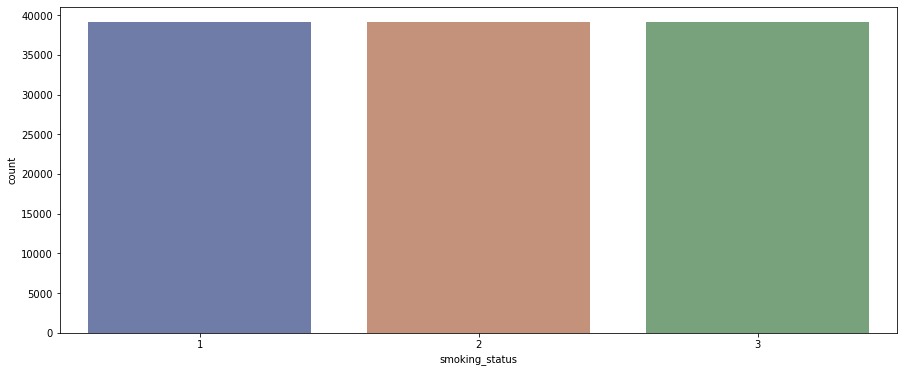

In [44]:
plt.figure(figsize = (15,6))
g = sns.countplot(data=data_y, x="smoking_status", palette="dark", alpha=.6)

### 7. Redução de dimensionalidade e Normalização

In [45]:
#resultados mantiveram-se semelhantes após o uso da normalização
'''
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(data_x)) #scaling the data

scaled_data.columns = data_x.columns
scaled_data.index = data_x.index

data_x = scaled_data
data_x
'''

'\nscalar = StandardScaler()\nscaled_data = pd.DataFrame(scalar.fit_transform(data_x)) #scaling the data\n\nscaled_data.columns = data_x.columns\nscaled_data.index = data_x.index\n\ndata_x = scaled_data\ndata_x\n'

In [46]:
#resultados ficaram piores após uso do kernel PCA
'''
pca = PCA(n_components = 9)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_x = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])
data_x
'''

"\npca = PCA(n_components = 9)\npca.fit(scaled_data)\ndata_pca = pca.transform(scaled_data)\ndata_x = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])\ndata_x\n"

### 8. Transformação de atributos

In [47]:
#pendente

---
---
# Classificadores

Esta seção será utilizada para criação de classificadores, na tentativa de identificar possíveis fumantes.

### Classificador Árvore de Decisão (Holdout)

Criação de conjuntos de treino e teste, para estratégia Holdout.

#### Criação de Árvore de Decisão, usando estratégia Holdout

Precisão:   0.6178183798772033
Revocação:  0.6312772431578453
F1 Score:   0.5991370513611313
Acurácia:   0.6836998706338939
Report:
              precision    recall  f1-score   support

           1       0.96      0.73      0.83       987
           2       0.41      0.77      0.53       317
           3       0.49      0.40      0.44       242

    accuracy                           0.68      1546
   macro avg       0.62      0.63      0.60      1546
weighted avg       0.77      0.68      0.71      1546

TPR [0.72644377 0.76656151 0.40082645]
TNR [0.94454383 0.70951993 0.92254601]
FPR [0.05545617 0.29048007 0.07745399]
FNR [0.27355623 0.23343849 0.59917355]



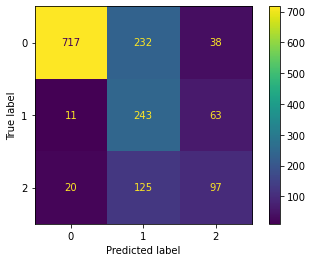

In [46]:
#cria classificador
smoking_tree_hold = tree.DecisionTreeClassifier(max_depth=4)
smoking_tree_hold.fit(data_x, data_y)

#gera predições
predictions = smoking_tree_hold.predict(x_test)
print_statistics(y_test, predictions)

In [53]:
#desenha a árvore de decisão
draw_tree(smoking_tree_hold, feature_names=x_train.columns,
          class_names=['Não Fumante', 'Ex-Fumante', 'Fumante'],          
          filename='tree_holdout.png')

#### [Link para imagem da árvore gerada](tree_holdout.png)

### Classificador Árvore de Decisão (Cross Validation)

In [ ]:
ini_time = datetime.datetime.now()

smoking_tree = tree.DecisionTreeClassifier()
strat_cross_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(estimator=smoking_tree, X=data_x.values, y=np.ravel(data_y.values), 
                         cv=strat_cross_val)

#imprime resultados de treinamento
print('Cross-Val:', np.mean(scores), '\n')

#imprime predições
predictions = cross_val_predict(smoking_tree, X=x_test.values, y=np.ravel(y_test.values))
print_statistics(y_test.values, predictions)

#desempenho
plt.figure(figsize = (5,3))
ax = sns.boxplot(x=scores)

end_time = datetime.datetime.now()
print('Time spent:', (end_time - ini_time))

In [ ]:
#desenha a árvore de decisão
#draw_tree(smoking_tree_hold, feature_names=x_train.columns,
#          class_names=['Não Fumante', 'Ex-Fumante', 'Fumante'], filename='tree_cross.png')

#### [Link para imagem da árvore gerada](tree_cross.png)

### Classificador RandomForest (Holdout)

Precisão:   0.7146266311083994
Revocação:  0.7486776906666792
F1 Score:   0.7270189969764348
Acurácia:   0.7849566679601604
Report:
              precision    recall  f1-score   support

           1       0.94      0.83      0.88      9603
           2       0.54      0.69      0.60      3020
           3       0.66      0.72      0.69      2839

    accuracy                           0.78     15462
   macro avg       0.71      0.75      0.73     15462
weighted avg       0.81      0.78      0.79     15462

TPR [0.83317713 0.69006623 0.72278971]
TNR [0.91449053 0.85621283 0.91800681]
FPR [0.08550947 0.14378717 0.08199319]
FNR [0.16682287 0.30993377 0.27721029]

Time spent: 0:00:32.806468


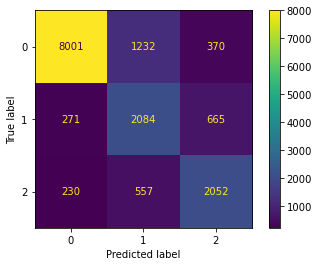

In [48]:
ini_time = datetime.datetime.now()

#cria classificador
smoking_forest = RandomForestClassifier()
smoking_forest.fit(data_x, np.ravel(data_y.values))

#gera predições
forest_pred = smoking_forest.predict(x_test)
print_statistics(y_test, forest_pred)

#calcula tempo
end_time = datetime.datetime.now()
print('Time spent:', (end_time - ini_time))

### Classificador RandomForest (CrossValidation)

In [ ]:
ini_time = datetime.datetime.now()

smoking_forest = RandomForestClassifier()
strat_cross_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

scores = cross_val_score(estimator=smoking_forest, X=data_x, y=np.ravel(data_y.values), 
                         cv=strat_cross_val)

#imprime resultados de treinamento
print('Cross-Val:', np.mean(scores), '\n')

#imprime predições
predictions = cross_val_predict(smoking_forest, X=x_test, y=np.ravel(y_test.values))
print_statistics(y_test, predictions)

#desempenho
plt.figure(figsize = (5,3))
ax = sns.boxplot(x=scores)

#calcula tempo
end_time = datetime.datetime.now()
print('Time spent:', (end_time - ini_time))

#### Distribuição de Classes no Conjunto de Testes

A distribuição de Não Fumantes (1), Ex-Fumantes (2) e Fumantes (3), para o conjunto de testes, está disponível na figura abaixo.

Tal figura justifica o número de amostras classificadas como Não Fumantes (1).

In [ ]:
plt.figure(figsize = (15,6))
g = sns.countplot(data=y_test, x="smoking_status", palette="dark", alpha=.6)

### Classificador Multilayer Perceptron

In [ ]:
#treina o algoritmo de MLP (Perceptron MultiCamadas)
mlp = MLPClassifier(random_state=1, verbose=False)
mlp.fit(data_x.values, np.ravel(data_y.values))

#realiza predições sobre o conjunto de testes e apura métricas
mlp_pred = mlp.predict(x_test.values)
print_statistics(y_test.values, mlp_pred)